In [1]:
# Step 0: Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 1: Fetch SPY data

# Using yfinance to get daily data for SPY (S&P 500 ETF)
spy_data = yf.download('SPY', start='2005-09-01', end='2025-09-01')

C:\Users\USER\AppData\Local\Temp\ipykernel_22728\2473317343.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download('SPY', start='2005-09-01', end='2025-09-01')
[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2: Flatten MultiIndex columns

# yfinance sometimes returns a MultiIndex; flatten it for simplicity
spy_data.columns = [f'{price}_{ticker}' for price, ticker in spy_data.columns]


In [4]:
# Step 3: Compute daily returns

# Simple daily percent change
spy_data['Daily_Return'] = spy_data['Close_SPY'].pct_change()

# Daily log returns
spy_data['Log_Return'] = np.log(spy_data['Close_SPY'] / spy_data['Close_SPY'].shift(1))

In [5]:
# Step 4: Inspect data

# Show first few rows to verify
spy_data[['Close_SPY', 'Daily_Return', 'Log_Return']].head()


,Close_SPY,Daily_Return,Log_Return
Date,,,
2005-09-01,84.235016,NaN,NaN
2005-09-02,84.083725,-0.001796,-0.001798
2005-09-06,85.067101,0.011695,0.011627
2005-09-07,85.211548,0.001698,0.001697
2005-09-08,84.929581,-0.003309,-0.003315


In [6]:
# Step 5: Summary statistics

# Quick stats for percent and log returns
daily_stats = spy_data['Daily_Return'].describe()
log_stats = spy_data['Log_Return'].describe()
print("Daily Return Stats:\n", daily_stats)
print("\nLog Return Stats:\n", log_stats)

Daily Return Stats:
 count    5029.000000
mean        0.000479
std         0.012208
min        -0.109423
25%        -0.003957
50%         0.000693
75%         0.005895
max         0.145198
Name: Daily_Return, dtype: float64

Log Return Stats:
 count    5029.000000
mean        0.000405
std         0.012216
min        -0.115886
25%        -0.003965
50%         0.000692
75%         0.005878
max         0.135577
Name: Log_Return, dtype: float64


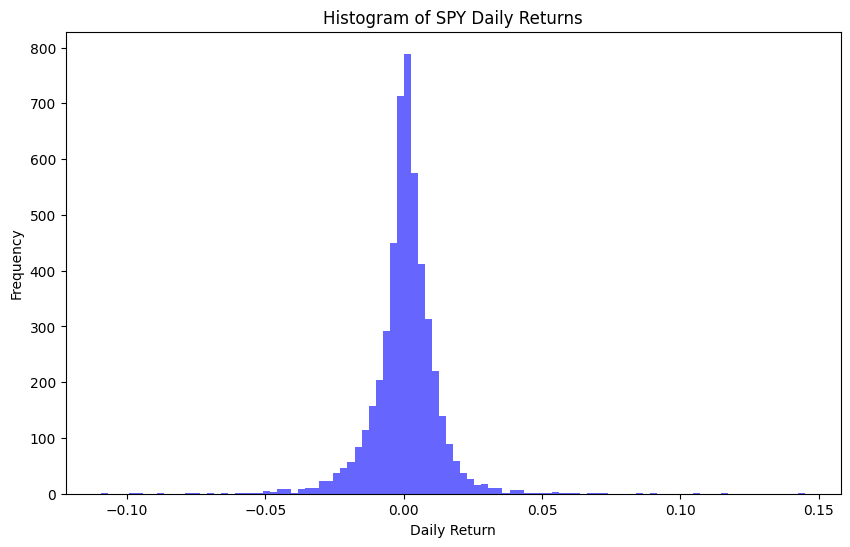

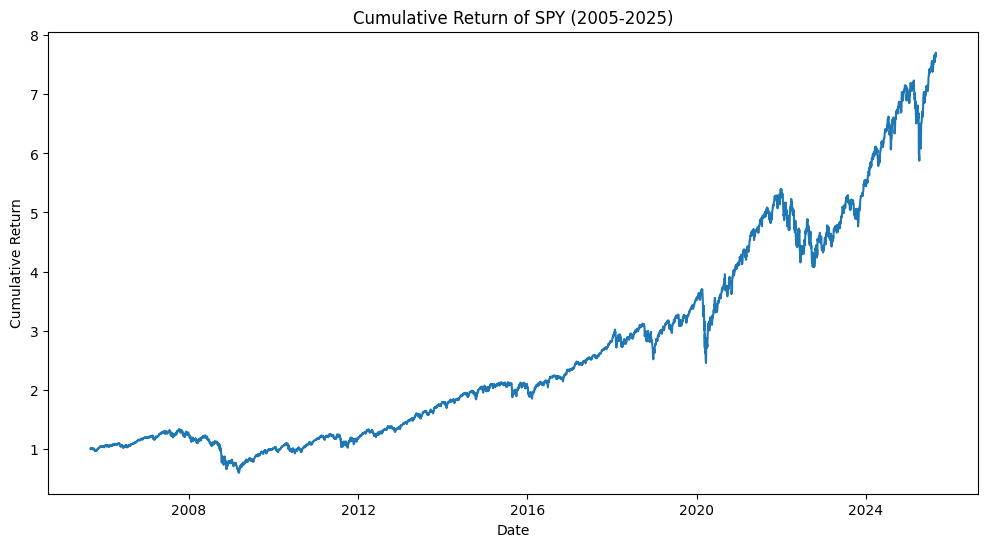

In [7]:
# Step 6: Visualize returns

# Histogram of daily returns
plt.figure(figsize=(10,6))
plt.hist(spy_data['Daily_Return'].dropna(), bins=100, alpha=0.6, color='blue')
plt.title("Histogram of SPY Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# Cumulative return over time
spy_data['Cumulative_Return'] = (1 + spy_data['Daily_Return']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(spy_data['Cumulative_Return'])
plt.title("Cumulative Return of SPY (2005-2025)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

In [8]:
# Step 7: Save processed data
# ------------------------------
spy_data.to_csv('SPY_Returns_Analysis.csv')
# This saves all columns including Daily_Return, Log_Return, and Cumulative_Return